# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
# Add debug info on the images
DEBUG = True

#importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read Test Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


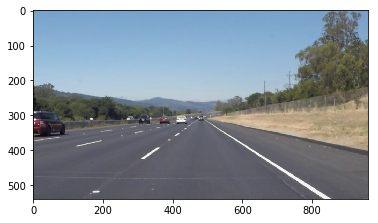

In [2]:
# reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_params(coords):
    """
    Calculates slope and length of the line from given coordiantes. 
    
    Returns a dict with all params.
    """
    x1, y1, x2, y2 = coords
    # changing starting point of the line for sorting by the lowest poing
    if y1 < y2:
        x1, y1, x2, y2 = x2, y2, x1, y1
    length = line_length(x1, y1, x2, y2)
    slope = line_slope(x1, y1, x2, y2)

    return { 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'slope': slope, 'length': length }

def line_length(x1, y1, x2, y2):
    """
    Calculates length of the line.
    """
    return math.sqrt((y2-y1)**2 + (x2-x1)**2)

def line_slope(x1, y1, x2, y2):
    """
    Calculates slope of the line.
    """    
    return (y2 - y1) / (x2 - x1)

def line_intercept(slope, x, y):
    """
    Calculates line intercept by given slope and any point of the line.
    Since `y = slope * x + intercept` => `intercept = y - slope * x`.
    """
    return y - slope * x

def x_coordinate(y, slope, intercept):
    """
    Calculates `x` coordinate by the `y`, `slope`, and `intercept`.
    """
    return int((y - intercept) / slope)

def remove_line_duplicates(lines, line):
    """
    Looks for lines with (almost) the same staring point and remove it from the `lines`.
    """
    x1, y1, x2, y2 = line['x1'], line['y1'], line['x2'], line['y2']
    for l in lines:
        if abs(l['x1'] - x1) < 4 and abs(l['y1'] - y1) < 4 and l != line:
            if line['length'] > l['length']:
                lines.remove(l)
            else:
                lines.remove(line)
            break
            
def normal_slope_lines(lines, median, stdev):
    """
    Finds lines which are close to median.
    """
    result = []
    for l in lines:
        if l['slope'] > (median - 2*stdev) and l['slope'] < (median + 2*stdev):
            result.append(l)
    return result

def extrapolate_to_bottom(image, line):
    """
    Extends given line to the bottom of the image.
    """
    y = int(image.shape[0])
    intercept = line_intercept(line['slope'], line['x1'], line['y1'])
    x = x_coordinate(y, line['slope'], intercept)
    line['x1'] = x
    line['y1'] = y
    line['intercept'] = intercept
    line['length'] = line_length(x, y, line['x2'], line['y2'])

def middle_line(lines, image):
    """
    Calculates the center of a lane line which is
    the middle line between left and right edge lines
    """
    if len(lines) == 1:
        return lines[0]
    x1 = int((lines[0]['x1'] + lines[1]['x1'])/2)
    y1 = lines[0]['y1']
    slope = (lines[0]['slope'] + lines[1]['slope'])/2
    intercept = line_intercept(slope, x1, y1)
    y2 = lines[0]['y2']
    x2 = x_coordinate(y2, slope, intercept)
    return { 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'slope': slope, 'intercept': intercept }

def extrapolate_to_top(all_lines, lines):
    """
    Extrapolates lines to the top.
    """
    sorted_lines = sorted(all_lines, key=lambda l: l['y2'])
    y = sorted_lines[0]['y2']
    for line in lines:
        x = x_coordinate(y, line['slope'], line['intercept'])
        line['x2'] = x
        line['y2'] = y
        line['length'] = line_length(line['x1'], line['y1'], line['x2'], line['y2'])
        
def lane_line(img, lines):
    """
    Calculates lane line for given array of detected lines
    """
    # Sort edge lines by lowest point
    sorted_lines = sorted(lines, key=lambda l: l['y1'], reverse=True)

    # Extrapolate four lowest lines to the bottom
    for line in sorted_lines[0:2]:
        extrapolate_to_bottom(img, line)

    return middle_line(sorted_lines[0:2], img)

def print_debug(img, lines):
    font = cv2.FONT_HERSHEY_SIMPLEX

    if len(lines) == 2:
        cv2.putText(img, ("right slope: {:.2f}".format(lines[1]['slope'])), (600,100), font, 1,(255,0,0),2)
        
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # 1. Filter out bad lines
    # 2. Find the lowest points for each edge line and extrapolate it to the bottom of the image
    # 3. Find the highest points for each edge line and extrapolate all the lines to the same height
    # 4. Calculate a middle line for each line
    

    
    left = []
    right = []
    lane_lines = []
    for l in lines:
        line = line_params(l[0])
        if line['slope'] == 0:
            # something wrong with the line, skipping it
            pass
        elif line['slope'] < 0:
            # left line
            left.append(line)
            remove_line_duplicates(left, line)
        else:
            # right line
            right.append(line)
            remove_line_duplicates(right, line)
                
    # rejecting lines with abnormal slope
    filtered_by_slope = normal_slope_lines(left, -0.72, 0.06952252833)
    if len(filtered_by_slope) > 1:
        # enough lines after rejecting?
        left = filtered_by_slope
        
    # the same for the right lines
    filtered_by_slope = normal_slope_lines(right, 0.634, 0.05025176863)
    if len(filtered_by_slope) > 1:
        # enough lines after rejecting?
        right = filtered_by_slope
    
    if len(left) > 0:
        # calculating left lane lines
        lane_lines.append(lane_line(img, left))
    if len(right) > 0:
        # calculating right lane lines
        lane_lines.append(lane_line(img, right))
    
    # extrapolating all lane lines to the top
    extrapolate_to_top(left + right, lane_lines)

    # drawing lines
    for i, line in enumerate(lane_lines):
        x1, y1, x2, y2 = line['x1'], line['y1'], line['x2'], line['y2']
        cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], 10)

    if DEBUG:
        print_debug(img, lane_lines)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    return lines

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(img, file_name=None):
    # Convert to grayscale
    gray = grayscale(img)

    # Denoise
    blur_gray = gaussian_blur(gray, 3)
    
    # Find edges with Canny algorithm
    # Will use threshold detection procedure described at:
    # http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    sigma = 0.33
    v = np.median(blur_gray)
    # apply automatic Canny edge detection using the computed median
    low_threshold = int(max(0, (1.0 - sigma) * v))
    high_threshold = int(min(255, (1.0 + sigma) * v))
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define vertices for region of interest and ...
    imshape = img.shape
    vertices = np.array([[(imshape[1]*0.03,imshape[0]),(imshape[1]*0.48, imshape[0] * 0.6), (imshape[1]*0.55, imshape[0]*0.6), (imshape[1]*0.97,imshape[0])]], dtype=np.int32)
    # filter out the rest of the image
    masked_edges = region_of_interest(edges, vertices)
    
    # Find all lines from the points using Hough Transform and draw it
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50   # minimum number of votes (intersections in Hough grid cell) 
    min_line_length = 100 # 30 # minimum number of pixels making up a line
    max_line_gap = 100 # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, lines)
    
    # Add image with lines to original image
    weighted = weighted_img(img, line_image)

    if DEBUG and file_name:
        cv2.imwrite("debug/01-gray-{}".format(file_name), gray)
        cv2.imwrite("debug/02-denoised-{}".format(file_name), blur_gray)
        cv2.imwrite("debug/03-edges-{}".format(file_name), edges)
        cv2.imwrite("debug/04-masked-edges-{}".format(file_name), masked_edges)
        
        all_lines_image = np.zeros_like(img)
        for l in lines:
            x1, y1, x2, y2 = l[0]
            cv2.line(all_lines_image, (x1, y1), (x2, y2), [255, 0, 0], 1)
        cv2.imwrite("debug/05-all-lines-{}".format(file_name), all_lines_image)
        
        cv2.imwrite("debug/06-line-image-{}".format(file_name), line_image)
        cv2.imwrite("debug/07-weighted-{}".format(file_name), weighted)
        
        
    return weighted

## Test on Images

The code below reads and processes all images from the `test_images` directory and copies results to into the `test_images_output` directory.

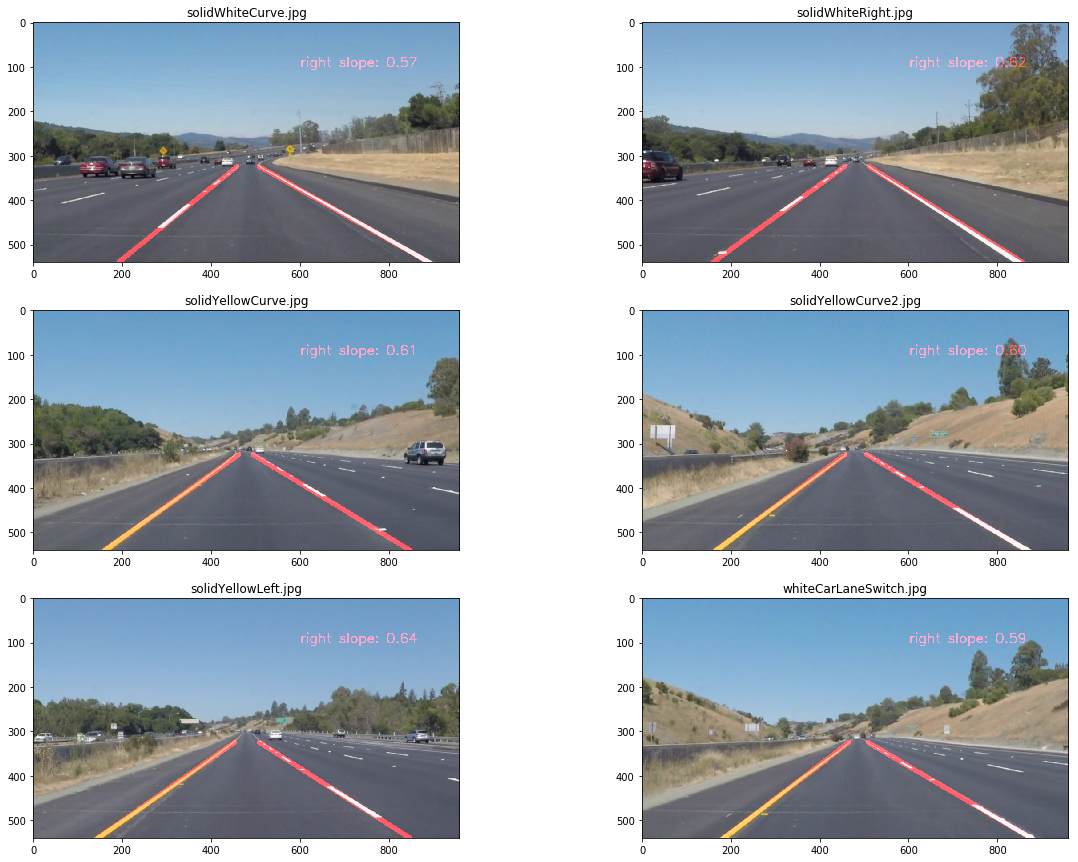

In [4]:
import os

input_path = "test_images"
file_names = os.listdir(input_path)

output_path = "test_images_output"

fig = plt.figure(figsize=(20, 15))
for i, file_name in enumerate(file_names):
    image = mpimg.imread(os.path.join(input_path, file_name))

    result = process_image(image, file_name)

    # show image
    a = fig.add_subplot(round(len(file_names) / 2), 2, i+1)
    a.imshow(result)
    a.set_title(file_name)
    
    # save image with lane lines to test_images_output dir
    mpimg.imsave(os.path.join(output_path, file_name), result)

## Test on Videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### White

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.85 s, sys: 834 ms, total: 3.69 s
Wall time: 6.84 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Yellow

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:26<00:00, 34.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.2 s, sys: 3.09 s, total: 13.3 s
Wall time: 26.9 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Looks like the same as yellow one.

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.78 s, sys: 2.86 s, total: 12.6 s
Wall time: 25.6 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))